In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

In [2]:
### READ DATA ###

train_hours = 80*7*24  # weeks x hours x days
test_hours = 15*7*24  # weeks x hours x days

df = pd.read_csv('bike-and-ped-counter.csv.zip', nrows=train_hours+test_hours, parse_dates=['Date'])

print(df.shape)
df.head()

(15960, 6)


,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01 00:00:00,15.0,0.0,2.0,2.0,11.0
1,2014-01-01 01:00:00,9.0,1.0,0.0,1.0,7.0
2,2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0


In [3]:
### FILL NAN ###

df['Ped South'] = df['Ped South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Ped North'] = df['Ped North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike South'] = df['Bike South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike North'] = df['Bike North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['BGT North of NE 70th Total'] = df['Ped South'] + df['Ped North'] + df['Bike South'] + df['Bike North']

df['Date'] = pd.to_datetime(df['Date'].dt.date)

In [4]:
### DAILY AGGREGATION ###

df_day = pd.DataFrame()
df_day['Ped South'] = df.groupby(df.Date)['Ped South'].sum()
df_day['Ped North'] = df.groupby(df.Date)['Ped North'].sum()
df_day['Bike South'] = df.groupby(df.Date)['Bike South'].sum()
df_day['Bike North'] = df.groupby(df.Date)['Bike North'].sum()
df_day['Total'] = df.groupby(df.Date)['BGT North of NE 70th Total'].sum()

df_day.index = pd.DatetimeIndex(df_day.index.values, freq=df_day.index.inferred_freq)

<AxesSubplot:>

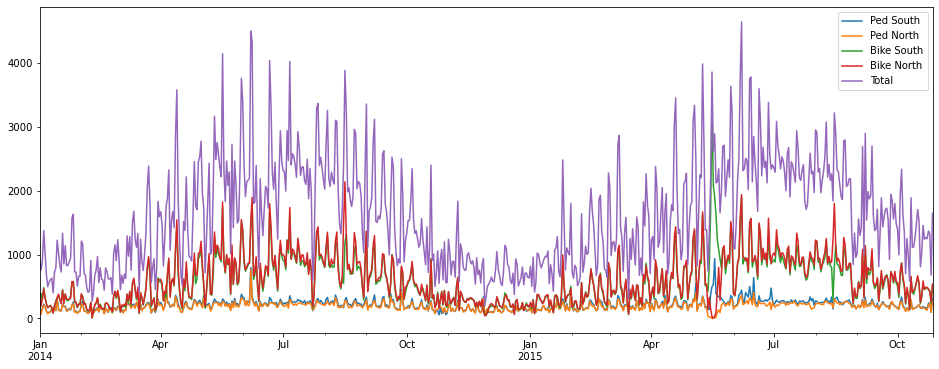

In [5]:
### PLOT DAILY DATA ###

df_day.plot(figsize=(16,6))

In [6]:
### TRAIN SPLIT ###

train = df_day[:(train_hours//24)].copy()

train.shape

(560, 5)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

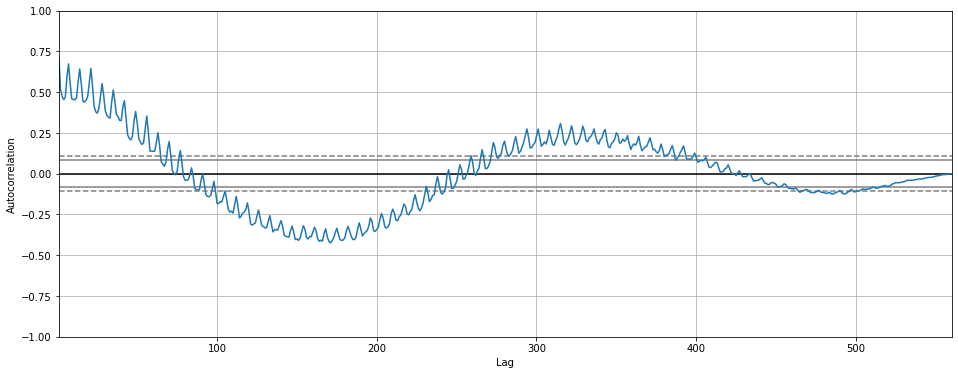

In [7]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['Total'])

In [8]:
### MONTHLY TRAIN MEAN ###

month_mean_train = train.groupby(train.index.month).mean()

In [9]:
### REMOVE LONG TERM SEASONALITY FROM TRAIN ###

train['Ped South'] = train.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
train['Ped North'] = train.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
train['Bike South'] = train.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
train['Bike North'] = train.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)
train['Total'] = train.apply(lambda x: x['Total'] - month_mean_train['Total'][x.name.month], axis=1)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

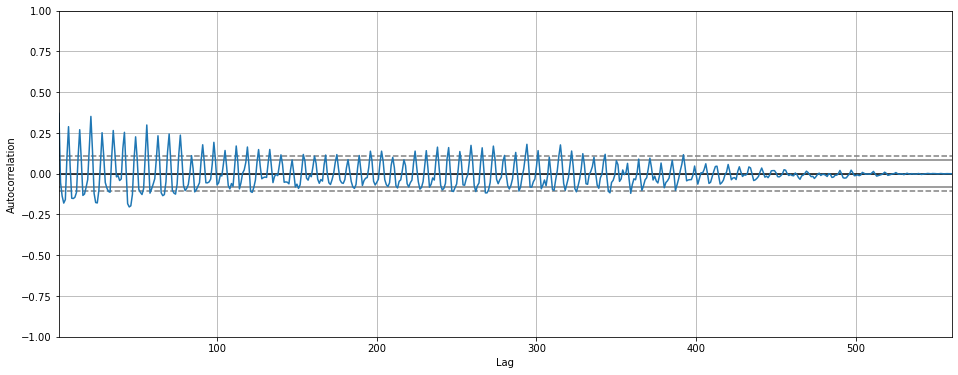

In [10]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['Total'])

# UNIVARIATE ANOMALY DETECTION

In [11]:
### TRAIN TEST SPLIT IN UNIVARIATE CASE ###

train_uni = train['Total'].copy()
test_uni = df_day['Total'][(train_hours//24):].copy()
test_uni = test_uni - test_uni.index.month.map(month_mean_train['Total'])

train.drop('Total', inplace=True, axis=1)

In [12]:
### FIND BEST UNIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

for p in range(6,9):
    for q in range(0,10):

        mod = SARIMAX(train_uni, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            AIC[(p,0,q)] = res.aic
        except:
            AIC[(p,0,q)] = np.inf
            
        if AIC[(p,0,q)] < best_aic:
            best_aic = AIC[(p,0,q)]
            best_order = (p,0,q)
            
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (6, 0, 5) BEST AIC: 8525.505916608898


In [13]:
### TRAIN BEST UNIVARIATE MODEL ###

mod = SARIMAX(train_uni, order=best_order, enforce_invertibility=False)
res = mod.fit(disp=False)
res.aic

8525.505916608898

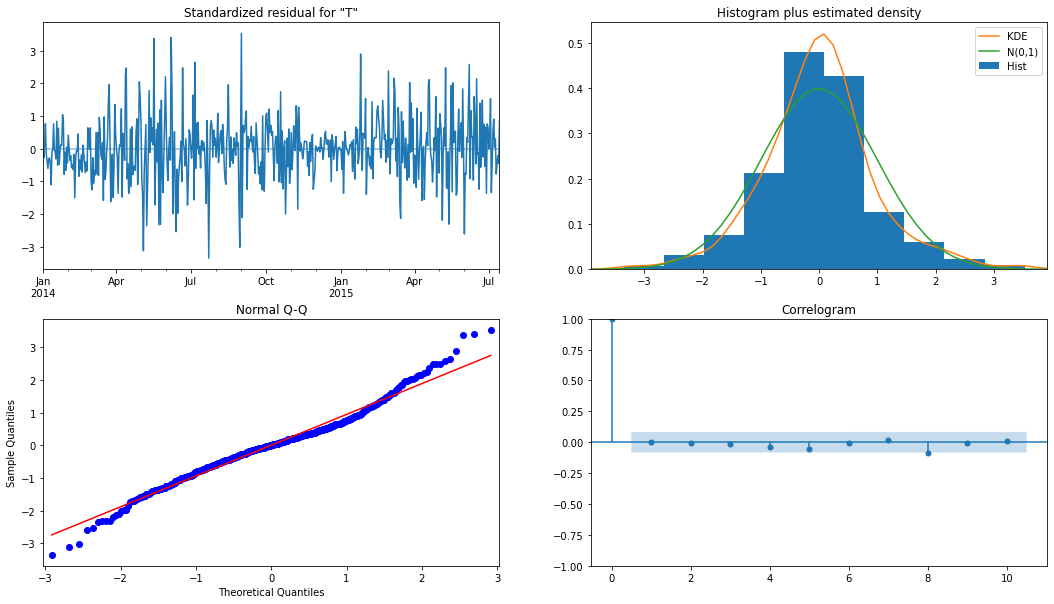

In [14]:
### PERFORMANCE OPTINAL MODEL ###

res.plot_diagnostics(figsize=(18,10))
plt.show()

In [15]:
### GET TRAIN FITTED VALUES ###

predict = res.get_prediction()
predicted_mean = predict.predicted_mean + predict.predicted_mean.index.month.map(month_mean_train['Total'])
train_uni = train_uni + train_uni.index.month.map(month_mean_train['Total'])
predict_ci = predict.conf_int(alpha=0.1)
predict_ci['lower Total'] = predict_ci.apply(lambda x: x['lower Total'] + month_mean_train['Total'][x.name.month], axis=1)
predict_ci['upper Total'] = predict_ci.apply(lambda x: x['upper Total'] + month_mean_train['Total'][x.name.month], axis=1)

residuals_mean = res.resid.mean()
residuals_std = res.resid.std()

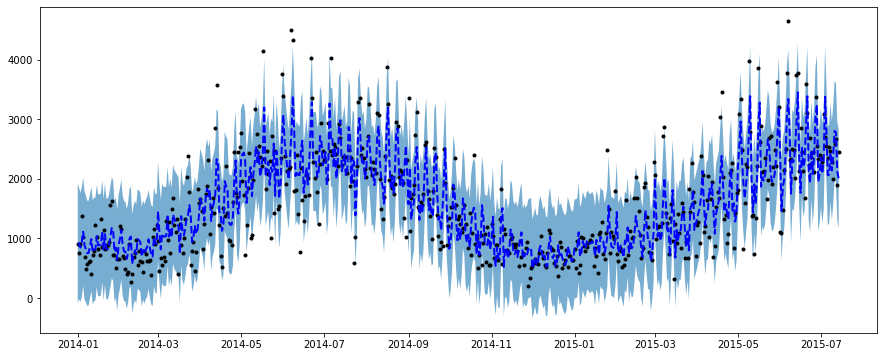

In [16]:
### PLOT TRAIN FITTED VALUES ###

plt.figure(figsize=(15,6))

plt.plot(train_uni, 'k.')
plt.plot(predicted_mean, linestyle='--', linewidth=2, color='blue')
plt.fill_between(predict_ci.index, predict_ci['lower Total'], predict_ci['upper Total'], alpha=0.6)

In [17]:
### ITERATIVE PREDICTIONS ON TEST DATA ###

point_forecast = res.get_prediction(end=mod.nobs)
point_ci = point_forecast.conf_int(alpha=0.1)

mean_pred = {point_forecast.predicted_mean.index[-1]: point_forecast.predicted_mean[-1]}
upper_pred = {point_ci.index[-1]: point_ci['upper Total'][-1]}
lower_pred = {point_ci.index[-1]: point_ci['lower Total'][-1]}

for t,row in test_uni[:-1].iteritems():
    
    row = pd.Series(row, index=[t])
    res = res.extend(row)
    point_forecast = res.get_prediction(1)
    point_ci = point_forecast.conf_int(alpha=0.1)
    
    mean_pred[point_forecast.predicted_mean.index[0]] = point_forecast.predicted_mean.values[0]
    upper_pred[point_ci.index[0]] = point_ci['upper Total'][0]
    lower_pred[point_ci.index[0]] = point_ci['lower Total'][0]
    
mean_pred = pd.Series(mean_pred)
upper_pred = pd.Series(upper_pred)
lower_pred = pd.Series(lower_pred)

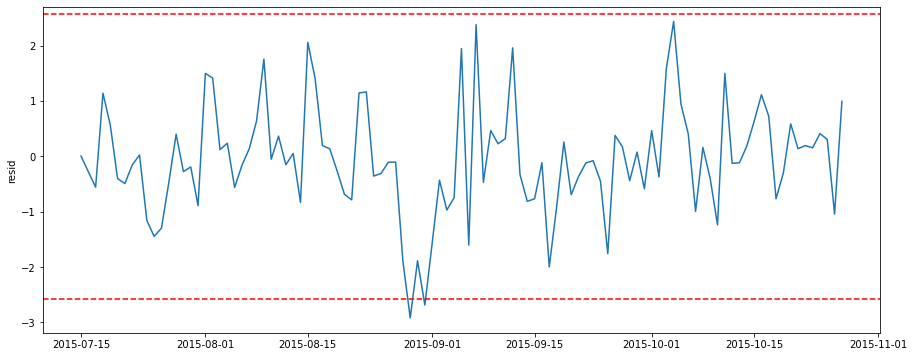

In [18]:
### TEST RESIDUALS ANALYSIS ###

alpha = 0.01
upper = stats.norm.ppf(1 - alpha/2)
lower = stats.norm.ppf(alpha/2)

residuals_test = test_uni - residuals_mean
residuals_test = (residuals_test - residuals_mean) / residuals_std

plt.figure(figsize=(15,6))
plt.plot(residuals_test)
plt.ylabel('resid')
plt.axhline(upper, c='red', linestyle='--')
plt.axhline(lower, c='red', linestyle='--')

In [19]:
### REVERSE SCALING TEST ITERATIVE PREDICTIONS ###

mean_pred = mean_pred + mean_pred.index.month.map(month_mean_train['Total'])
upper_pred = upper_pred + upper_pred.index.month.map(month_mean_train['Total'])
lower_pred = lower_pred + lower_pred.index.month.map(month_mean_train['Total'])
test_uni = test_uni + test_uni.index.month.map(month_mean_train['Total'])

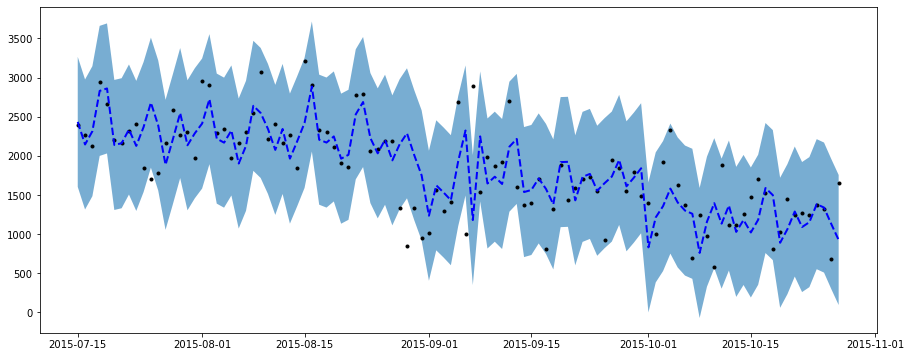

In [20]:
### PLOT TEST ITERATIVE PREDICTIONS ###

plt.figure(figsize=(15,6))

plt.plot(test_uni, 'k.')
plt.plot(mean_pred, linestyle='--', linewidth=2, color='blue')
plt.fill_between(mean_pred.index, lower_pred, upper_pred, alpha=0.6)

# MULTIVARIATE ANOMALY DETECTION

In [21]:
### FIND BEST MULTIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train)
    var_result = model.fit(maxlags=i)
    AIC[i] = var_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 7 BEST AIC: 34.896281239608705


In [22]:
### TRAIN BEST MULTIVARIATE MODEL ###

var = VAR(endog=train)
var_result = var.fit(maxlags=best_order)

var_result.aic

34.896281239608705

In [23]:
### COMPUTE TRAIN T2 METRIC ###

residuals_mean = var_result.resid.values.mean(axis=0)
residuals_std = var_result.resid.values.std(axis=0)

residuals = (var_result.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))

In [24]:
### COMPUTE UCL ###

m = var_result.nobs
p = var_result.resid.shape[-1]
alpha = 0.01

UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) *(p*(m+1)*(m-1)/(m*m-m*p))
UCL

13.511575593053317

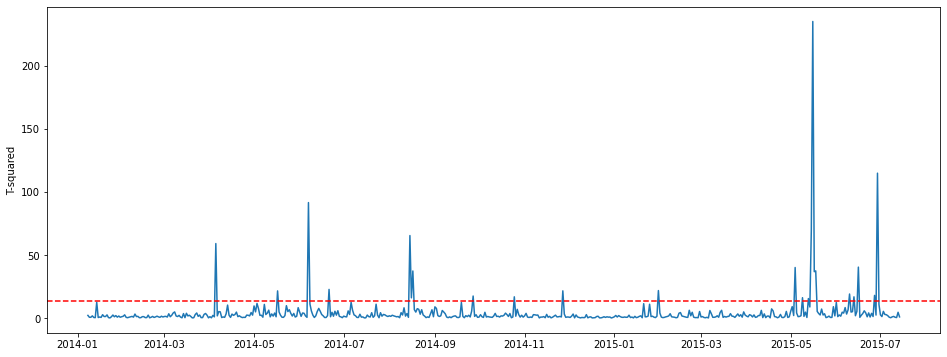

In [25]:
### PLOT TRAIN T2 METRIC ###

plt.figure(figsize=(16,6))
plt.plot(train.index[best_order:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [26]:
### TEST SPLIT IN MULTIVARIATE CASE ###

test = df_day[(train_hours//24-best_order):].copy()
test.drop('Total', inplace=True, axis=1)

test.shape

(112, 4)

In [27]:
### REMOVE LONG TERM SEASONALITY FROM TEST ###

test['Ped South'] = test.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
test['Ped North'] = test.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
test['Bike South'] = test.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
test['Bike North'] = test.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)

In [28]:
### ITERATIVE PREDICTIONS ON TEST DATA ###

pred = []

for i in range(best_order, len(test)):
    
    pred.append(var_result.forecast(test.iloc[i-best_order:i].values, steps=1))
    
pred = np.vstack(pred)
pred.shape

(105, 4)

In [29]:
### COMPUTE TEST T2 METRIC ###

residuals_test = test.iloc[best_order:].values - pred
residuals_test = (residuals_test - residuals_mean) / residuals_std

T_test = np.diag((residuals_test).dot(cov_residuals).dot(residuals_test.T))

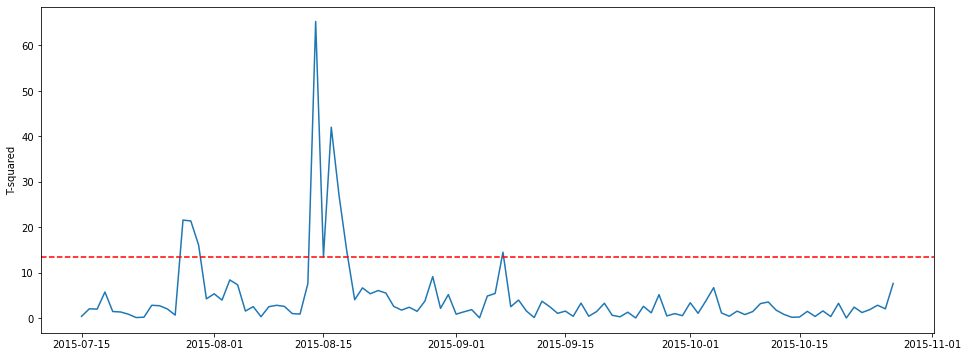

In [30]:
### PLOT TEST T2 METRIC ###

plt.figure(figsize=(16,6))
plt.plot(test.iloc[best_order:].index, T_test)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')